In [1]:
#Importation des bibliothèques
import json
import requests
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, LSTM
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import datetime as dt


I. Récupération et formatage des données

In [2]:
#Initialisation 
endpoint = 'https://min-api.cryptocompare.com/data/histoday'
#Initialisation de la date d'aujourd'hui
today = dt.date.today().strftime('%Y-%m-%d')
end = today
#Initialisation du nombre de jours à télécharger
limit = 2000
#Formatage de la date au format adapté à l'API
end_timestamp = int(dt.datetime.strptime(end, '%Y-%m-%d').timestamp())
# Requête avec les dates spécifiques (Nous utiliserons les données du Bitcoin)
res = requests.get(f'{endpoint}?fsym=BTC&tsym=EUR&limit={limit}&toTs={end_timestamp}')
df = pd.DataFrame(json.loads(res.content)['Data'])
df = df.set_index('time')
df.index = pd.to_datetime(df.index, unit='s')
# Supprimer les données au-delà de la date de début
df.head(5)



,high,low,open,volumefrom,volumeto,close,conversionType,conversionSymbol
time,,,,,,,,
2018-06-24,5380.81,4967.26,5291.82,15614.33,80322859.89,5280.81,direct,
2018-06-25,5423.51,5211.51,5280.81,12197.61,64941417.90,5344.80,direct,
2018-06-26,5359.66,5200.63,5344.80,10371.84,55084926.42,5215.20,direct,
2018-06-27,5342.45,5173.22,5213.12,8928.53,46921674.37,5305.41,direct,
2018-06-28,5329.49,5048.15,5308.20,9186.23,48022815.59,5070.32,direct,


In [3]:
#suppression des 2 colonnes string
df = df.drop(['conversionType', 'conversionSymbol'], axis=1)
df.tail(5)

,high,low,open,volumefrom,volumeto,close
time,,,,,,
2023-12-11,40713.81,37339.84,40699.50,5233.32,2.028378e+08,38321.06
2023-12-12,39021.24,37699.22,38321.06,2961.57,1.140797e+08,38415.65
2023-12-13,39981.60,37680.66,38415.65,2926.62,1.132409e+08,39432.85
2023-12-14,39674.64,38232.53,39432.85,2485.71,9.714204e+07,39154.70
2023-12-15,39271.27,38239.54,39154.70,1902.56,7.376230e+07,38516.53


In [4]:
# Compter les valeurs manquantes par colonne
missing_values = df.isnull().sum()
print(missing_values)
# Calculer le nombre total de valeurs manquantes
total_missing = missing_values.sum()
print("Nombre total de valeurs manquantes :", total_missing)
# Gestion des données manquantes
start_date = df.index.min()
end_date = df.index.max()
all_dates = pd.date_range(start=start_date, end=end_date, freq='D')
df = df.reindex(all_dates)
df['close'] = df['close'].interpolate()

high          0
low           0
open          0
volumefrom    0
volumeto      0
close         0
dtype: int64
Nombre total de valeurs manquantes : 0


In [5]:
# Modification du format de l'index des dates
df.index = df.index.strftime('%d-%m-%Y')
# Affichage des cinq premières lignes avec le nouvel index
df.head(5)

,high,low,open,volumefrom,volumeto,close
24-06-2018,5380.81,4967.26,5291.82,15614.33,80322859.89,5280.81
25-06-2018,5423.51,5211.51,5280.81,12197.61,64941417.90,5344.80
26-06-2018,5359.66,5200.63,5344.80,10371.84,55084926.42,5215.20
27-06-2018,5342.45,5173.22,5213.12,8928.53,46921674.37,5305.41
28-06-2018,5329.49,5048.15,5308.20,9186.23,48022815.59,5070.32


II. Analyse et visualisations de données

In [6]:
#Analyse descriptive du dataset
df.describe()

,high,low,open,volumefrom,volumeto,close
count,2001.000000,2001.000000,2001.000000,2001.000000,2.001000e+03,2001.000000
mean,20641.202224,19654.923143,20164.548546,9655.785767,1.817836e+08,20181.183773
std,14353.997673,13617.252318,14006.649524,8224.755117,2.275178e+08,14008.784358
min,2877.610000,2794.750000,2848.240000,486.020000,1.134218e+07,2848.240000
25%,7925.050000,7615.730000,7797.400000,4706.390000,5.498523e+07,7798.850000
50%,19768.230000,18817.690000,19340.150000,7829.460000,1.006561e+08,19370.040000
75%,30096.390000,27934.050000,29075.010000,11971.040000,2.172593e+08,29113.610000
max,59647.190000,57244.070000,58276.660000,141790.660000,2.980086e+09,58276.660000


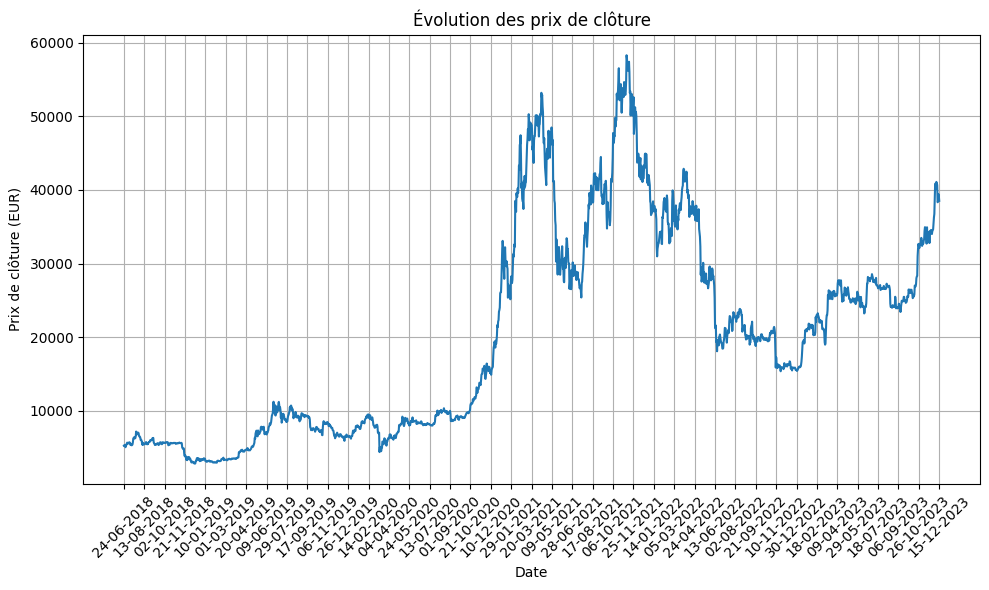

In [7]:
#Visualisation des prix de clôture avec les dates sur l'axe des abscisses
plt.figure(figsize=(10, 6))
plt.plot(df.index, df['close'], label='Prix de clôture')
plt.title('Évolution des prix de clôture')
plt.xlabel('Date')
plt.ylabel('Prix de clôture (EUR)')
plt.grid(True)
#Formater les dates sur l'axe x
plt.xticks(df.index[::50], rotation=45)  # Récupère toutes les 50 dates pour éviter la surcharge
plt.tight_layout()  # Ajustement pour éviter que les dates se chevauchent
plt.show()


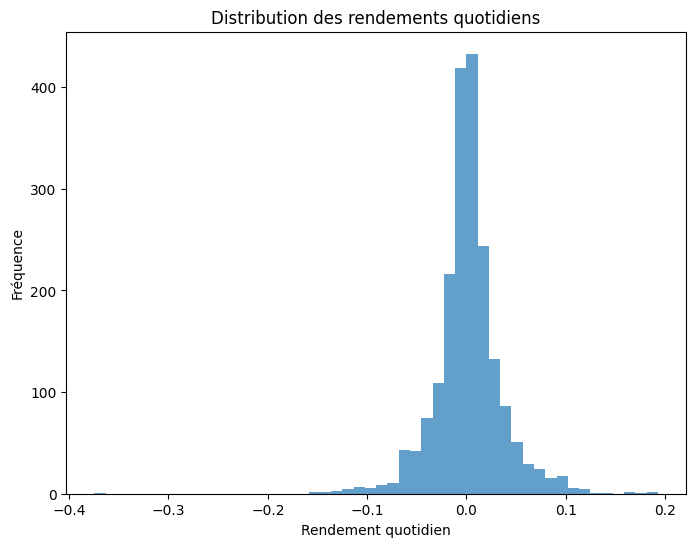

Volatilité des prix : 0.03504148859085519


In [8]:
# Calcul de l'écart-type des rendements quotidiens
daily_returns = df['close'].pct_change()
volatility = daily_returns.std()
# Histogramme des rendements quotidiens
plt.figure(figsize=(8, 6))
plt.hist(daily_returns.dropna(), bins=50, alpha=0.7)
plt.title('Distribution des rendements quotidiens')
plt.xlabel('Rendement quotidien')
plt.ylabel('Fréquence')
plt.show()
print(f"Volatilité des prix : {volatility}")



In [9]:
#Préparation des données de moyenne mobile à 10 et 30 jours (Moving Average)
ma10 = df.close.rolling(10).mean()
ma30 = df.close.rolling(30).mean()

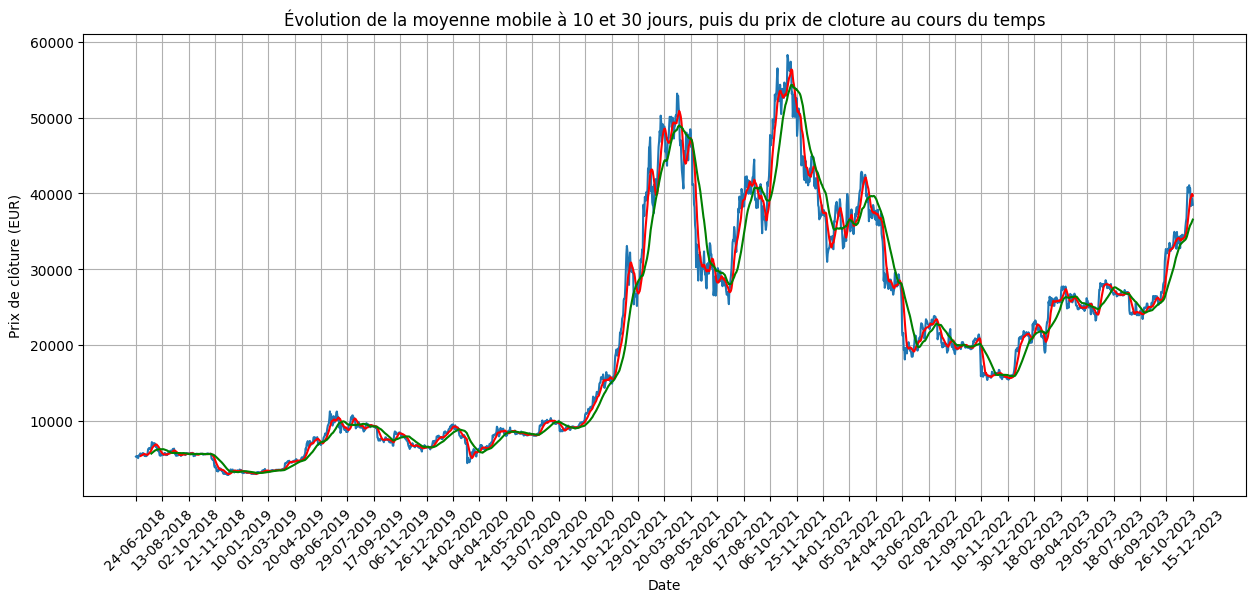

In [10]:
#Visualisation de la courbe de la moyenne mobile à 10 et 30 jours et du prix de clôture en fonction du temps
plt.figure(figsize=(15,6))
plt.plot(df.close)
plt.plot(ma10, 'r')
plt.plot(ma30,'g')
plt.title('Évolution de la moyenne mobile à 10 et 30 jours, puis du prix de cloture au cours du temps')
plt.xticks(df.index[::50], rotation=45)  # Récupère toutes les 50 dates pour éviter la surcharge
plt.xlabel('Date')
plt.ylabel('Prix de clôture (EUR)')
# Afficher la grille si nécessaire
plt.grid(True)

III. Division des données

3.1. Division en Training set et Testing set

In [11]:
#Réinitialisation des index
df=df.reset_index()
df.head()

,index,high,low,open,volumefrom,volumeto,close
0,24-06-2018,5380.81,4967.26,5291.82,15614.33,80322859.89,5280.81
1,25-06-2018,5423.51,5211.51,5280.81,12197.61,64941417.90,5344.80
2,26-06-2018,5359.66,5200.63,5344.80,10371.84,55084926.42,5215.20
3,27-06-2018,5342.45,5173.22,5213.12,8928.53,46921674.37,5305.41
4,28-06-2018,5329.49,5048.15,5308.20,9186.23,48022815.59,5070.32


In [12]:
# Calcul de l'index pour diviser les données (70% pour l'entraînement, 30% pour le test)
train_size = 0.7
split_index = int(len(df) * train_size)
# Séparation des données en ensembles d'entraînement et de test
df_training = pd.DataFrame(df['close'][:split_index])  # Données d'entraînement (70%)
df_testing = pd.DataFrame(df['close'][split_index:])   # Données de test (30%)
# Affichage des tailles des ensembles
print("Taille de l'ensemble d'entraînement :", df_training.shape)
print("Taille de l'ensemble de test :", df_testing.shape)

Taille de l'ensemble d'entraînement : (1400, 1)
Taille de l'ensemble de test : (601, 1)


In [13]:
df_training.tail(3)

,close
1397,37393.32
1398,36821.84
1399,36584.45


In [14]:
df_testing.head(3)

,close
1400,36528.79
1401,37746.68
1402,35845.40


3.2. Division en x_train, y_train, x_test, y_test

Données d'entrainement: x_train, y_train 

In [15]:
#Scaling de la Traing Data et transformation en matrice
scaler = MinMaxScaler(feature_range=(0,1))
df_training_array = scaler.fit_transform(df_training)
df_training_array.shape

(1400, 1)

In [16]:
#Division de x_train et y_train par pas de 10 jours
x_train = []
y_train = []

for i in range(10, df_training_array.shape[0]):
  x_train.append(df_training_array[i-10: i ])
  y_train.append(df_training_array[i, 0])

In [17]:
#Conversion de x_train et y_train en matrices
x_train, y_train = np.array(x_train), np.array(y_train)
print(x_train.shape)
print(y_train.shape)

(1390, 10, 1)
(1390,)


Données de test: x_test, y_test

In [18]:
#Charger les 10 dernières lignes du Training Set pour les ajouter au (début) Testing Set
past_10_days = df_training.tail(10)
#Ajouter les 10 dernières lignes aux Data Frame final du Testing
df_testing = pd.concat([past_10_days, df_testing])
df_testing.shape

(611, 1)

In [19]:
#Scaling pour changer l'échelle du Testing Set à [0-1]
df_testing_array = scaler.fit_transform(df_testing)
df_testing_array.shape

(611, 1)

In [20]:
#Diviser le testing set en x_test et y_test
x_test = []
y_test = []

for i in range(10, df_testing_array.shape[0]):
  x_test.append(df_testing_array[i-10 : i ])
  y_test.append(df_testing_array[i, 0])

In [21]:
#Conversion de x_test et y_test en matrices
x_test, y_test = np.array(x_test), np.array(y_test)
print(x_test.shape)
print(y_test.shape)

(601, 10, 1)
(601,)


IV. Entrainement d'un modèle LSTM

In [22]:
# Fonction pour construire le modèle LSTM
def build_model(input_shape):
    # Création d'un modèle séquentiel
    model = Sequential()

    # Première couche LSTM avec 50 unités, activation ReLU, retourne des séquences, et input shape correspondant aux données
    model.add(LSTM(units=50, activation='relu', return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.2))  # Dropout pour régulariser le modèle, évitant le surapprentissage

    # Deuxième couche LSTM avec 60 unités, activation ReLU, retourne des séquences
    model.add(LSTM(units=60, activation='relu', return_sequences=True))
    model.add(Dropout(0.3))  # Dropout pour régulariser le modèle

    # Troisième couche LSTM avec 80 unités, activation ReLU, retourne des séquences
    model.add(LSTM(units=80, activation='relu', return_sequences=True))
    model.add(Dropout(0.4))  # Dropout pour régulariser le modèle

    # Quatrième couche LSTM avec 120 unités, activation ReLU
    model.add(LSTM(units=120, activation='relu'))
    model.add(Dropout(0.5))  # Dropout pour régulariser le modèle

    # Couche Dense (entièrement connectée) avec une unité pour la prédiction
    model.add(Dense(units=1))

    # Retourne le modèle construit
    return model

In [23]:
# Création du modèle en utilisant la fonction build_model
model = build_model(input_shape=(10, 1))
model.summary()  # Affiche le résumé du modèle pour examiner les paramètres


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 10, 50)            10400     
                                                                 
 dropout (Dropout)           (None, 10, 50)            0         
                                                                 
 lstm_1 (LSTM)               (None, 10, 60)            26640     
                                                                 
 dropout_1 (Dropout)         (None, 10, 60)            0         
                                                                 
 lstm_2 (LSTM)               (None, 10, 80)            45120     
                                                                 
 dropout_2 (Dropout)         (None, 10, 80)            0         
                                                                 
 lstm_3 (LSTM)               (None, 120)               

In [24]:
#Compilation et training du modèle
model.compile(optimizer='adam', loss = 'mean_squared_error')
history=model.fit(x_train, y_train, epochs = 500, validation_split=0.1)

"""Temps d'exécution de la cellule: Environ 15 minutes"""


Epoch 1/500

40/40 [==============================] - 9s 59ms/step - loss: 0.0544 - val_loss: 0.0105
Epoch 2/500
40/40 [==============================] - 1s 32ms/step - loss: 0.0089 - val_loss: 0.0101
Epoch 3/500
40/40 [==============================] - 1s 30ms/step - loss: 0.0075 - val_loss: 0.0023
Epoch 4/500
40/40 [==============================] - 2s 40ms/step - loss: 0.0067 - val_loss: 0.0062
Epoch 5/500
40/40 [==============================] - 1s 35ms/step - loss: 0.0052 - val_loss: 0.0028
Epoch 6/500
40/40 [==============================] - 1s 36ms/step - loss: 0.0047 - val_loss: 0.0027
Epoch 7/500
40/40 [==============================] - 1s 30ms/step - loss: 0.0045 - val_loss: 0.0073
Epoch 8/500
40/40 [==============================] - 1s 35ms/step - loss: 0.0067 - val_loss: 0.0025
Epoch 9/500
40/40 [==============================] - 1s 38ms/step - loss: 0.0045 - val_loss: 0.0019
Epoch 10/500
40/40 [==============================] - 2s 39ms/step - loss: 0.0049 - val_loss: 0.00

"Temps d'exécution de la cellule: Environ 15 minutes"

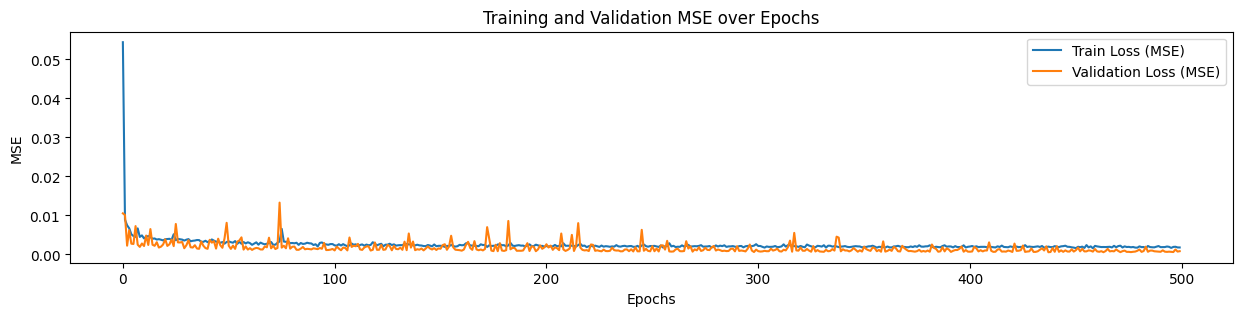

In [25]:
# Affichage de l'historique d'entraînement (MSE)
plt.figure(figsize=(15,3))
plt.plot(history.history['loss'], label='Train Loss (MSE)')
plt.plot(history.history['val_loss'], label='Validation Loss (MSE)')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.title('Training and Validation MSE over Epochs')
plt.show()

V. Enregistrement du modèle

In [26]:
#Enregistrement du modèle
model.save('cryptoforetellmodel.h5')

c:\Users\ngale\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


VI. Évaluation du modèle

In [27]:
#Prédictions pour x_test
y_pred = model.predict(x_test)
y_pred.shape

19/19 [==============================] - 1s 6ms/step


(601, 1)

In [28]:
#Annuler la normalisation
y_pred = scaler.inverse_transform(y_pred.reshape(-1, 1))
y_testing = scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred[-1], y_testing[-1]

(array([38858.445], dtype=float32), array([38516.53]))

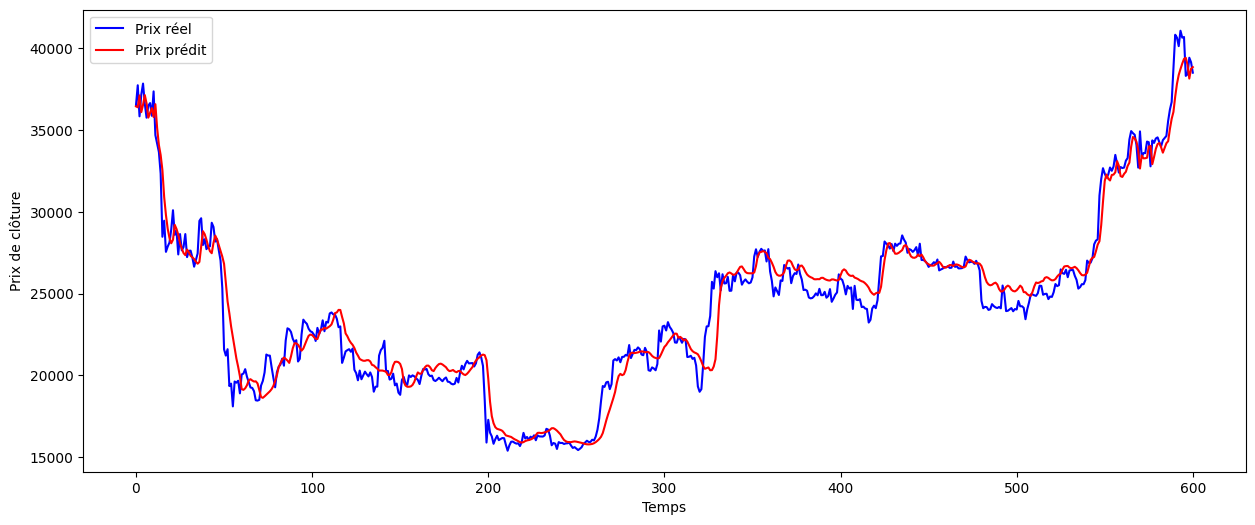

In [29]:
#Visionner la courbe des prédiction du cours de clôture VS le cours du prix de clôture réels
plt.figure(figsize=(15,6))
plt.plot(y_testing, 'b', label = 'Prix réel')
plt.plot(y_pred, 'r', label='Prix prédit')
plt.xlabel('Temps')
plt.ylabel('Prix de clôture')
plt.legend()
plt.show()

In [30]:
#Prédiction du prix de clôture pour demain
x = []
x.append(y_test[-10:])
x=np.array(x)
x_reshaped = np.reshape(x, (1, 10, 1))
pred_tomorrow = model.predict(x_reshaped)
pred_tomorrow.shape

1/1 [==============================] - 0s 35ms/step


(1, 1)

In [31]:
pred_tomorrow_n = scaler.inverse_transform(pred_tomorrow.reshape(-1, 1))

In [32]:
print("Le prix de clôture pour aujourd'hui est : {:.2f}".format(y_testing[-1][0]))
print("Le prix de clôture prédit pour demain est : {:.2f}".format(float(pred_tomorrow_n)))


Le prix de clôture pour aujourd'hui est : 38516.53
Le prix de clôture prédit pour demain est : 38573.66


C:\Users\ngale\AppData\Local\Temp\ipykernel_10340\3659392485.py:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print("Le prix de clôture prédit pour demain est : {:.2f}".format(float(pred_tomorrow_n)))
